<center>

# ME546 - Assignment #5

_Author - Austin Milne_

</center>


## Problem 1

**Problem Statement:** We have three barometers that measure atmospheric pressure and 
through that we can measure the elevation of the sensor. Each barometric sensor has a 
different noise profile. These noise profiles are presented in the data included. The data indicates the measurement of those sensors for a monotonic change of elevation motion and the outputs are normalized between -1 and 1. The goal of this assignment is to fuse those measurement using a simple Mamdani Type-I Fuzzy Inference System (MATLAB> Fuzzy Logic Designer toolbox). 

In [2]:
# Typical Math Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Import data from mat file
import scipy.io
data = scipy.io.loadmat('Assignment_5_data.mat')

# Read into Dictionary of NP arrays
sensors = [
    "X1",
    "X2",
    "X3",
]
sensor_data = {}
for sensor in sensors:
    sensor_data[sensor] = {}
    sensor_data[sensor]["raw"] = np.array(data[sensor][0]).T

### Part 1 & 2
Use a low pass filter or smooth function of Mathlab with a window size of 11: 
smooth(X1,11). This allows you to compute the low passed signals of each sensor with less effect of noise. E.g., X1smooth=smooth(X1,11).

For the purpose of this assignment, a 1D uniform filter is used with a sub-array size of 11. This is mathematically identical to the MatLab function `smooth(X1,11)`. The filter is applied to each of the three sensor readings.

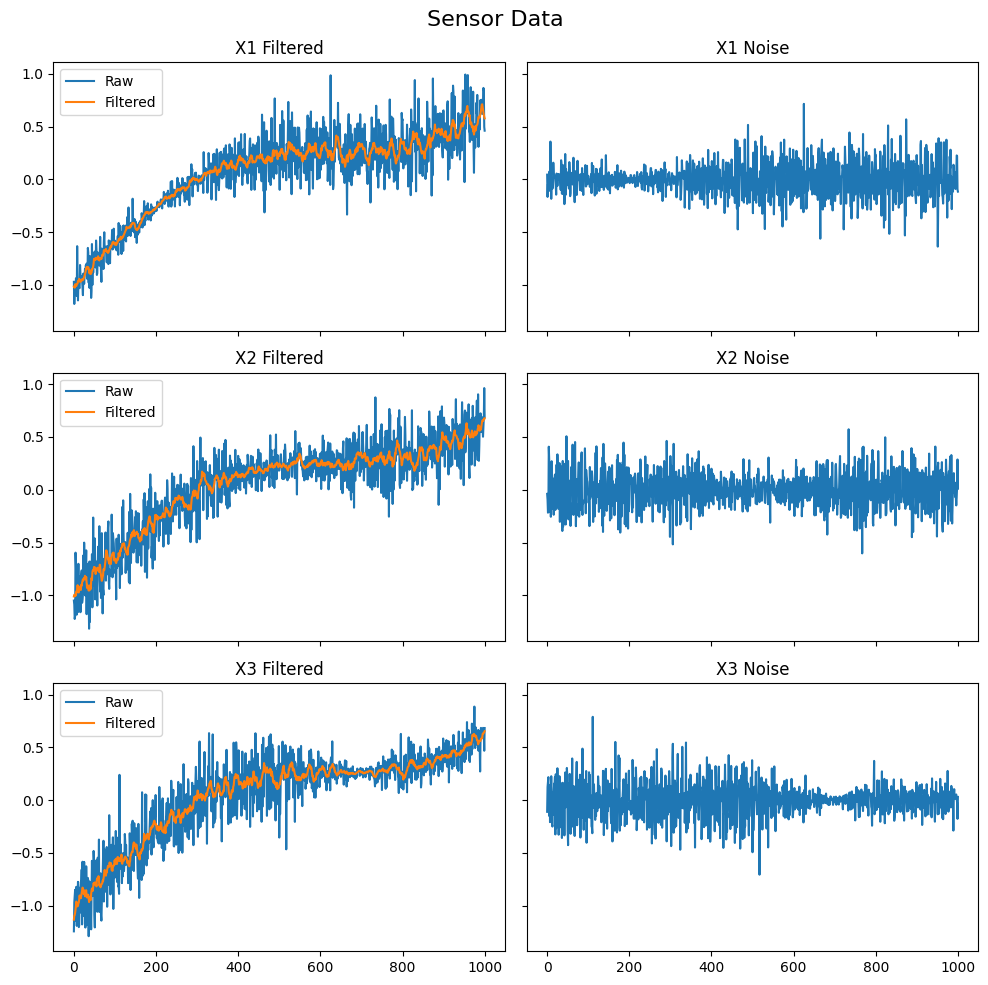

Variance of Raw and Filtered Data
                X1        X2        X3
raw       0.176658  0.183417  0.180994
filtered  0.152249  0.154390  0.156204


In [3]:
# Apply running average smoothing filter to data, calculate noise profile
for sensor in sensors:
    sensor_data[sensor]["filtered"] = uniform_filter1d(sensor_data[sensor]["raw"].T, size=11, mode='nearest').T
    sensor_data[sensor]["noise"] = sensor_data[sensor]["raw"] - sensor_data[sensor]["filtered"]

# Plot the unsmoothed and the smoothed data
fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
fig.suptitle("Sensor Data", fontsize=16)
for i, sensor in enumerate(sensors):
    sub = ax[i][0]
    sub.plot(sensor_data[sensor]["raw"], label="Raw")
    sub.plot(sensor_data[sensor]["filtered"], label="Filtered")
    sub.set_title(f"{sensor} Raw")
    sub.set_title(f"{sensor} Filtered")
    sub.legend()
    noise = ax[i][1]
    noise.plot(sensor_data[sensor]["noise"], label="Noise")
    noise.set_title(f"{sensor} Noise")
plt.tight_layout()
plt.savefig("out/sensor_data.png")
plt.show()

# Determine the variance of the raw and filtered data
variances = {}
for sensor in sensors:
    variances[sensor] = {
        "raw": np.var(sensor_data[sensor]["raw"]),
        "filtered": np.var(sensor_data[sensor]["filtered"]),
    }
variances = pd.DataFrame(variances)
print("Variance of Raw and Filtered Data")
print(variances)

### Part 3 - Std. Dev. in Noise
For every window of 100 sample, compute the standard deviation of noise. Use disjoint shifted windows for simplicity. STD_Noise_X1(1)=std(NoiseX1(1,1:100) ), STD_Noise_X1(2)=std(NoiseX1(1,101:200) ), ...

In [4]:
# Calculate the standard deviation for each 100 sample chunk of the noise
indexes = np.arange(0, sensor_data["X1"]["noise"].shape[0], 100)
for i, sensor in enumerate(sensors):
    sensor_data[sensor]["noise_stddev"] = []
    for j, index in enumerate(indexes):
        if j == len(indexes) - 1:
            break
        start = index
        end = indexes[j+1] - 1
        noise_data = {
            "start": start,
            "end": end,
            "std_dev": np.std(sensor_data[sensor]["noise"][start:end])
        }
        sensor_data[sensor]["noise_stddev"].append(noise_data)
        
# Create dataframe of the noise standard deviations
noise_stddev = {}
noise_stddev["Range"] = [f"{x['start']} - {x['end']}" for x in sensor_data["X1"]["noise_stddev"]]
for sensor in sensors:
    noise_stddev[sensor] = [x["std_dev"] for x in sensor_data[sensor]["noise_stddev"]]
noise_stddev = pd.DataFrame(noise_stddev, )
print("Noise Standard Deviation")
print(noise_stddev)


Noise Standard Deviation
       Range        X1        X2        X3
0     0 - 99  0.100424  0.207416  0.199986
1  100 - 199  0.067225  0.200459  0.195553
2  200 - 299  0.064838  0.149050  0.178181
3  300 - 399  0.114400  0.172602  0.213026
4  400 - 499  0.160492  0.104208  0.204015
5  500 - 599  0.187597  0.095901  0.162741
6  600 - 699  0.187572  0.151681  0.063536
7  700 - 799  0.179501  0.207270  0.078772
8  800 - 899  0.197677  0.175657  0.101334
9  900 - 999  0.190059  0.179412  0.098351


# Part 4-7 - Fuzzy Logic System

Now design a fuzzy inference system with 3 inputs, each indicating the certainty of each sensor for a window of samples, and 3 outputs to indicate the raw weight of each sensor in the fusion.

Use these operators:  
- And method: MIN 
- Or method: MAX 
- Implication: MIN 
- Aggregation: MAX 
- Defuzzification: centroid

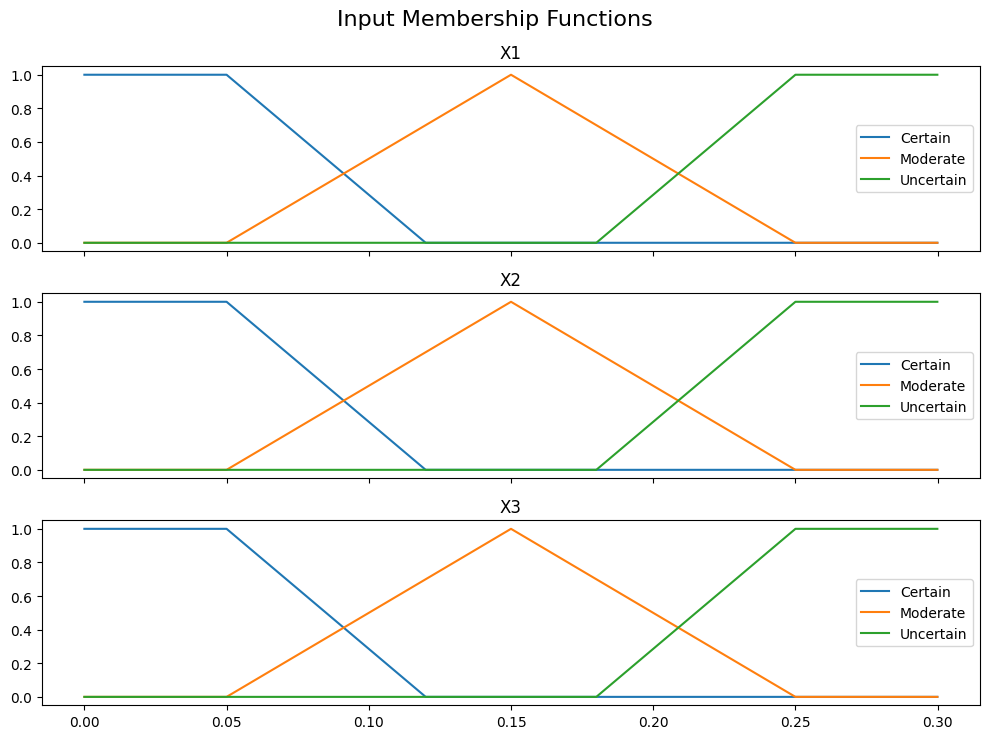

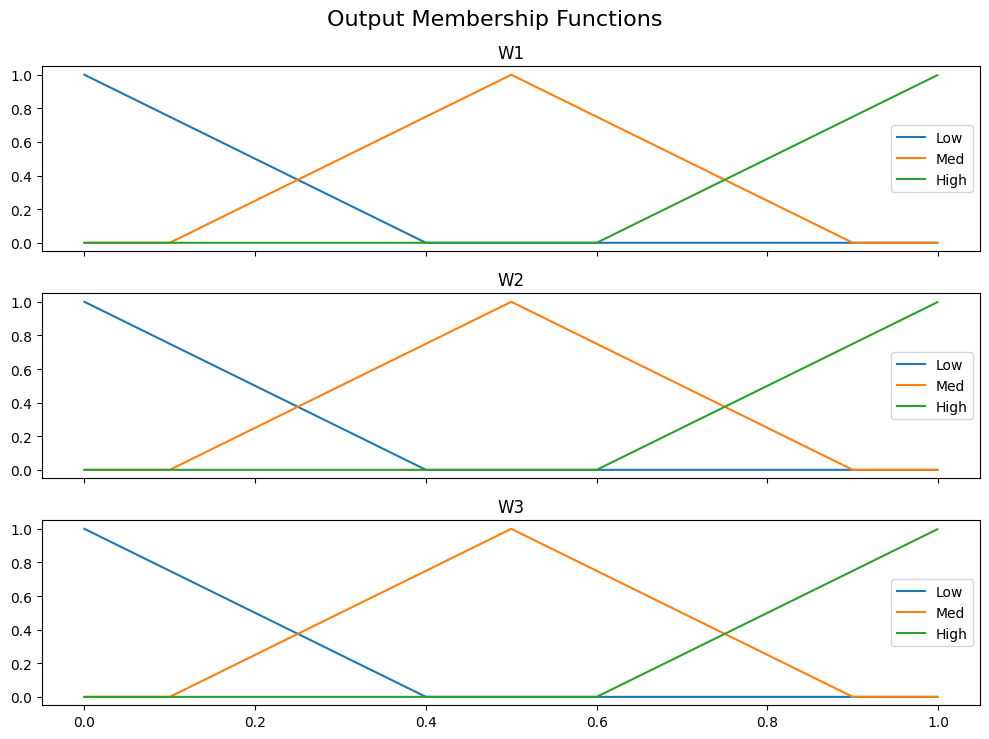

In [5]:
# Use a fuzzy inference system to determine what weights to use for each sensor
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Antecedents
X1 = ctrl.Antecedent(np.arange(0.0, 0.3, 0.0001), 'X1')
X2 = ctrl.Antecedent(np.arange(0.0, 0.3, 0.0001), 'X2')
X3 = ctrl.Antecedent(np.arange(0.0, 0.3, 0.0001), 'X3')
# Consequents
W1 = ctrl.Consequent(np.arange(0.0, 1.0, 0.001), 'W1')
W2 = ctrl.Consequent(np.arange(0.0, 1.0, 0.001), 'W2')
W3 = ctrl.Consequent(np.arange(0.0, 1.0, 0.001), 'W3')

# Membership Functions
X1['Certain'] = fuzz.trapmf(X1.universe, [-0.113, -0.0125, 0.05, 0.12])
X2['Certain'] = fuzz.trapmf(X2.universe, [-0.113, -0.0125, 0.05, 0.12])
X3['Certain'] = fuzz.trapmf(X3.universe, [-0.113, -0.0125, 0.05, 0.12])
X1['Moderate'] = fuzz.trimf(X1.universe, [0.05, 0.15, 0.25])
X2['Moderate'] = fuzz.trimf(X2.universe, [0.05, 0.15, 0.25])
X3['Moderate'] = fuzz.trimf(X3.universe, [0.05, 0.15, 0.25])
X1['Uncertain'] = fuzz.trapmf(X1.universe, [0.18, 0.25, 0.313, 0.412])
X2['Uncertain'] = fuzz.trapmf(X2.universe, [0.18, 0.25, 0.313, 0.412])
X3['Uncertain'] = fuzz.trapmf(X3.universe, [0.18, 0.25, 0.313, 0.412])
W1['Low'] = fuzz.trimf(W1.universe, [-0.4, 0, 0.4])
W2['Low'] = fuzz.trimf(W2.universe, [-0.4, 0, 0.4])
W3['Low'] = fuzz.trimf(W3.universe, [-0.4, 0, 0.4])
W1['Med'] = fuzz.trimf(W1.universe, [0.1, 0.5, 0.9])
W2['Med'] = fuzz.trimf(W2.universe, [0.1, 0.5, 0.9])
W3['Med'] = fuzz.trimf(W3.universe, [0.1, 0.5, 0.9])
W1['High'] = fuzz.trimf(W1.universe, [0.6, 1, 1.4])
W2['High'] = fuzz.trimf(W2.universe, [0.6, 1, 1.4])
W3['High'] = fuzz.trimf(W3.universe, [0.6, 1, 1.4])

# Plot the input member functions
fig, ax = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)
fig.suptitle("Input Membership Functions", fontsize=16)
for i, set in enumerate([X1, X2, X3]):
    sub = ax[i]
    for case in set.terms.keys():
        sub.plot(set.universe, set.terms[case].mf, label=case)
    sub.legend()
    sub.set_title(f"{set.label}")
plt.tight_layout()
plt.savefig("out/input_membership_functions.png")
plt.show()

# Plot the output member functions
fig, ax = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)
fig.suptitle("Output Membership Functions", fontsize=16)
for i, set in enumerate([W1, W2, W3]):
    sub = ax[i]
    for case in set.terms.keys():
        sub.plot(set.universe, set.terms[case].mf, label=case)
    sub.legend()
    sub.set_title(f"{set.label}")
plt.tight_layout()
plt.savefig("out/output_membership_functions.png")
plt.show()


## --- RULES ------------------------------ ##
rules = [
    ctrl.Rule(X1['Certain'] & X2['Certain'] & X3['Certain'],   (W1['Med'],  W2['Med'], W3['Med']),    label='Rule 1'),
    ctrl.Rule(X1['Uncertain'] & X2['Certain'] & X3['Certain'], (W1['Low'],  W2['High'], W3['High']),  label='Rule 2'),
    ctrl.Rule(X1['Certain'] & X2['Uncertain'] & X3['Certain'], (W1['High'], W2['Low'],  W3['High']),  label='Rule 3'),
    ctrl.Rule(X1['Certain'] & X2['Certain'] & X3['Uncertain'], (W1['High'], W2['High'], W3['Low']),   label='Rule 4'),
    ctrl.Rule(X1['Certain'] & X2['Moderate'] & X3['Moderate'], (W1['High'], W2['Med'],  W3['Med']),   label='Rule 5'),
    ctrl.Rule(X1['Moderate'] & X2['Certain'] & X3['Moderate'], (W1['Med'],  W2['High'], W3['Med']),   label='Rule 6'),
    ctrl.Rule(X1['Moderate'] & X2['Moderate'] & X3['Certain'], (W1['Med'],  W2['Med'],  W3['High']),  label='Rule 7'),
]

# # Visualize 1 rule
# rules[0].view()


## --- MODEL ------------------------------ ##
Model = ctrl.ControlSystem(rules)
Sim = ctrl.ControlSystemSimulation(Model)

In [6]:
# Pass in input for each sensor
Inputs = [
    {
        "in": {
            "X1": sensor_data["X1"]["noise_stddev"][index]["std_dev"],
            "X2": sensor_data["X2"]["noise_stddev"][index]["std_dev"],
            "X3": sensor_data["X3"]["noise_stddev"][index]["std_dev"],
        },
        "start": sensor_data["X1"]["noise_stddev"][index]["start"],
        "end": sensor_data["X1"]["noise_stddev"][index]["end"],
    } for index in range(0, len(sensor_data["X1"]["noise_stddev"]))
]

# Calculate the weights for the each input
Weights = []
for i, input in enumerate(Inputs):
    Sim.inputs(input["in"])
    Sim.compute()
    Weights.append({
        "Range": f"{input['start']} - {input['end']}",
        "Start": input["start"],
        "End": input["end"],
        "W1": Sim.output["W1"],
        "W2": Sim.output["W2"],
        "W3": Sim.output["W3"],
    })
Weights_df = pd.DataFrame(Weights)

# Combine the weights with the noise standard deviations
Combined = noise_stddev.join(Weights_df.set_index("Range"), on="Range").set_index("Range")
print("Combined")
print(Combined)

Combined
                 X1        X2        X3  Start  End        W1        W2  \
Range                                                                     
0 - 99     0.100424  0.207416  0.199986      0   99  0.825946  0.500000   
100 - 199  0.067225  0.200459  0.195553    100  199  0.843586  0.500000   
200 - 299  0.064838  0.149050  0.178181    200  299  0.857853  0.500000   
300 - 399  0.114400  0.172602  0.213026    300  399  0.807389  0.500000   
400 - 499  0.160492  0.104208  0.204015    400  499  0.500000  0.821101   
500 - 599  0.187597  0.095901  0.162741    500  599  0.500000  0.831534   
600 - 699  0.187572  0.151681  0.063536    600  699  0.500000  0.500000   
700 - 799  0.179501  0.207270  0.078772    700  799  0.500000  0.500000   
800 - 899  0.197677  0.175657  0.101334    800  899  0.500000  0.500000   
900 - 999  0.190059  0.179412  0.098351    900  999  0.500000  0.500000   

                 W3  
Range                
0 - 99     0.500000  
100 - 199  0.500000  
20

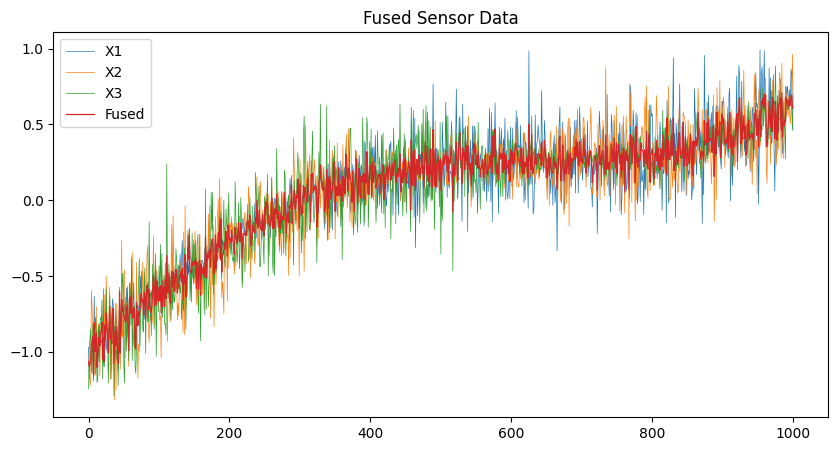

In [7]:
# Array of Raw Data
raw_data = np.stack([sensor_data[sensor]['raw'] for sensor in sensors], axis=-1)

# Array of normalized weights
weight_set = []
for i in range(0, len(raw_data)):
    for k, weight in enumerate(Weights):
        if weight["Start"] <= i <= weight["End"]:
            w1 = weight["W1"]
            w2 = weight["W2"]
            w3 = weight["W3"]
            total = w1 + w2 + w3
            w1 = w1 / total
            w2 = w2 / total
            w3 = w3 / total
            weight_set.append([w1, w2, w3])
            break
    else:
        weight_set.append([1.0/3, 1.0/3, 1.0/3])
weight_set = np.array(weight_set)

# Fused sensor data
fused_data = np.sum(raw_data * weight_set, axis=-1)

# Plot the raw and fused data
fig = plt.figure(figsize=(10, 5))
plt.plot(sensor_data["X1"]["raw"], label="X1", linewidth=0.5)
plt.plot(sensor_data["X2"]["raw"], label="X2", linewidth=0.5)
plt.plot(sensor_data["X3"]["raw"], label="X3", linewidth=0.5)
plt.plot(fused_data, label="Fused", linewidth=0.9)
plt.title("Fused Sensor Data")
plt.legend()
plt.savefig("out/fused_sensor_data.png")

## Quiz Questions

### Q1
Obtain the raw weights for combining the sensors using this FIS for the inputs in the window of 201-300 samples: answer should be three weight values (note that you can simply use the rule viewer and put the input noise std  as the input to the FIS to obtain those weights)

In [8]:
# Get the raw weights for i=[201,300] ([200-299] in Python)
print(f'Weights for i=[201,300]: W1={Weights[2]["W1"]:<08.6}, W2={Weights[2]["W2"]:<08.6}, W3={Weights[2]["W3"]:<08.6}')

Weights for i=[201,300]: W1=0.857853, W2=0.500000, W3=0.500000


### Q2
Obtain the raw weights for the window of samples from 801-900

In [9]:
print(f'Weights for i=[801,900]: W1={Weights[8]["W1"]:<08.6}, W2={Weights[8]["W2"]:<08.6}, W3={Weights[8]["W3"]:<08.6}')

Weights for i=[801,900]: W1=0.500000, W2=0.500000, W3=0.824794


### Q3
to fuse the sensors we need to normalize those weight by sum of the weights; 
Perform the normalization
$$
X_{\text{fused}} = \frac{w_1 * X_1 + w_2 * X_2 + w_3 * X_3}{w_1 + w_2 + w_3}
$$
obtain the mean of fused measurements for the window of 201-300 samples and window of 801-900 samples.

In [10]:
print(f'Mean of fused data for i=[201, 300]: {np.mean(fused_data[200:299]):<08.6}')
print(f'Mean of fused data for i=[801, 900]: {np.mean(fused_data[800:899]):<08.6}')

Mean of fused data for i=[201, 300]: -0.14117
Mean of fused data for i=[801, 900]: 0.340797


## References
- Fuzzy Logic Library - SciKit-Fuzzy, [https://github.com/scikit-fuzzy/scikit-fuzzy](https://github.com/scikit-fuzzy/scikit-fuzzy),